In [11]:
import numpy as np
import tensorflow_probability as tfp
import pandas as pd
from bisect import bisect_left
from scipy import special
from scipy.special import erf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy.linalg import inv
import tensorflow as tf
import scipy.linalg
import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable
from scipy.stats.distributions import chi2
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from gpflow.utilities import print_summary, positive
np.set_printoptions(suppress=True)
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from gpflow import set_trainable
from utilities import (compute_prior_hyperparameters, trapezoidal_area, fit_1d_model, predict_in_observations, fit_Hand, y_exp_Hand, y_exp, fit_3d_model, find_nearest, K_log, K_multiplicative)

f64 = gpflow.utilities.to_default_float

In [12]:
################################################################################################
# It is immportant to set up prior for all parameters, including the variance of the likelihood
################################################################################################

df = pd.read_csv('YonetaniData1.csv', sep=";")
df = df.iloc[1:]
drug_name = 'Yonetani_'


Effect = df['FracInhib'].values.reshape(-1,1).copy()
Dose_A = df['Conc.ADP'].values.astype(float).copy()
Dose_B = df['Conc.ADPr'].values.astype(float).copy()
Dose_AB = np.concatenate((Dose_A.reshape(-1,1), Dose_B.reshape(-1,1)),  axis=1)

Effect_B = df[df['Conc.ADP'] == 0]['FracInhib'].to_numpy().reshape(-1,1).astype(float)
Effect_A = df[df['Conc.ADPr'] == 0]['FracInhib'].to_numpy().reshape(-1,1).astype(float)
Dose_A = df[df['Conc.ADPr']==0]['Conc.ADP'].to_numpy().reshape(-1,1).astype(float)
Dose_B = df[df['Conc.ADP']==0]['Conc.ADPr'].to_numpy().reshape(-1,1).astype(float)

In [135]:
# hyperparameters of the priors
A_max  = np.max(Dose_A)
B_max = np.max(Dose_B)

alphaA, betaA = compute_prior_hyperparameters(A_max, 0.1*A_max)
alphaB, betaB = compute_prior_hyperparameters(B_max, 0.1*B_max)

eff_max_a = np.max(Effect_A)
eff_max_b = np.max(Effect_B)
eff_max = np.max([eff_max_a, eff_max_b])

alpha_var, beta_var = compute_prior_hyperparameters(eff_max, 0.1*eff_max)


In [136]:
alphaA/(betaA**2)

0.025

In [137]:
# Fit univariate model

k_univ = K_log()


m = gpflow.models.GPR(data=(Dose_A, Effect_A), kernel=k_univ, mean_function=None)

m.likelihood.variance.assign(0.01)
set_trainable(m.likelihood.variance, False)
init_lengthscale_da = alphaA
m.kernel.lengthscale.assign(init_lengthscale_da)
m.kernel.variance.assign(alpha_var/beta_var)

m.likelihood.variance.prior = tfp.distributions.Gamma(np.float64(2.0), np.float64(2.0))
m.kernel.variance.prior = tfp.distributions.Gamma(np.float64(alpha_var), np.float64(beta_var))


m.kernel.lengthscale.prior = tfp.distributions.Gamma(np.float64(alphaA), np.float64(betaA))


opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

print('Model for A')
print_summary(m)

#m.kernel.lengthscale.assign(0.77)
#m.kernel.variance.assign(949.0)

num_predict = 50
xx_A = np.linspace(0.0, np.max(Dose_A),  num_predict).reshape(num_predict, 1)
xx_B = np.linspace(0.0, np.max(Dose_B),  num_predict).reshape( num_predict, 1)

mean2, Cov2 = m.predict_f(xx_A)

#mean2 = pd.DataFrame(mean2)
#Cov2 = pd.DataFrame(Cov2)
## plot
plt.figure(figsize=(12, 6))
plt.plot(Dose_A, Effect_A, "kx", mew=2)
plt.plot(xx_A, mean2,"C0", lw=2, color='red')
plt.fill_between(
    xx_A[:, 0],
    mean2[:, 0] - 1.96 * np.sqrt(Cov2[:,0]),
    mean2[:, 0] + 1.96 * np.sqrt( Cov2[:,0]),
    color="red",
    alpha=0.2
)
plt.show()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'


InvalidArgumentError:  Input matrix is not invertible.
	 [[node MatrixTriangularSolve_2 (defined at /Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/gpflow/optimizers/scipy.py:146) ]] [Op:__inference__tf_eval_1307634]

Errors may have originated from an input operation.
Input Source operations connected to node MatrixTriangularSolve_2:
 Cholesky (defined at /Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/gpflow/models/gpr.py:71)

Function call stack:
_tf_eval


In [ ]:
#Fit univariate model

k_univ = K_log()

m = gpflow.models.GPR(data=(Dose_B, Effect_B), kernel=k_univ, mean_function=None)

m.likelihood.variance.assign(0.01)
set_trainable(m.likelihood.variance, False)
print('alphaB', alphaB/betaB)

init_lengthscale_db = (alphaB/betaB)/3
m.kernel.lengthscale.assign(init_lengthscale_db)
m.kernel.variance.assign(alpha_var/beta_var)

m.likelihood.variance.prior = tfp.distributions.Gamma(np.float64(2.0), np.float64(2.0))
m.kernel.variance.prior = tfp.distributions.Gamma(np.float64(alpha_var), np.float64(beta_var))


m.kernel.lengthscale.prior = tfp.distributions.Gamma(np.float64(alphaB), np.float64(betaB))

opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

#m.kernel.lengthscale.assign(103.0)
#m.kernel.variance.assign(949.0)

print('Model for B')
print_summary(m)

num_predict = 50
xx_A = np.linspace(0.0, np.max(Dose_A),  num_predict).reshape(num_predict, 1)
xx_B = np.linspace(0.0, np.max(Dose_B),  num_predict).reshape( num_predict, 1)

mean2, Cov2 = m.predict_f(xx_B)

#mean2 = pd.DataFrame(mean2)
#Cov2 = pd.DataFrame(Cov2)
## plot
plt.figure(figsize=(12, 6))
plt.plot(Dose_B, Effect_B, "kx", mew=2)
plt.plot(xx_B, mean2,"C0", lw=2, color='red')
plt.fill_between(
    xx_B[:, 0],
    mean2[:, 0] - 1.96 * np.sqrt(Cov2[:,0]),
    mean2[:, 0] + 1.96 * np.sqrt( Cov2[:,0]),
    color="red",
    alpha=0.2
)
plt.show()

alphaB 475.0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Model for B
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 877.74  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────

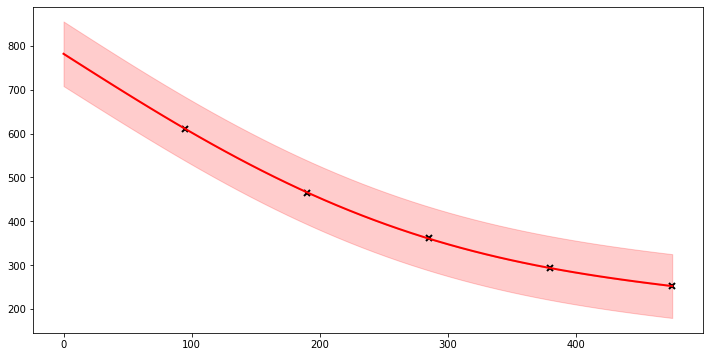

In [138]:
#Fit univariate model

k_univ = gpflow.kernels.RBF()

m = gpflow.models.GPR(data=(Dose_B, Effect_B), kernel=k_univ, mean_function=None)

m.likelihood.variance.assign(0.01)
m.likelihood.variance.assign(0.01)

set_trainable(m.likelihood.variance, False)

print('alphaB', alphaB/betaB)

init_lengthscale_db = (alphaB/betaB)
m.kernel.lengthscales.assign(init_lengthscale_db)
m.kernel.variance.assign(alpha_var/beta_var)

m.likelihood.variance.prior = tfp.distributions.Gamma(np.float64(2.0), np.float64(2.0))
m.kernel.variance.prior = tfp.distributions.Gamma(np.float64(alpha_var), np.float64(beta_var))


m.kernel.lengthscales.prior = tfp.distributions.Gamma(np.float64(alphaB), np.float64(betaB))

opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

#m.kernel.lengthscale.assign(103.0)
#m.kernel.variance.assign(949.0)

print('Model for B')
print_summary(m)

num_predict = 50
xx_A = np.linspace(0.0, np.max(Dose_A),  num_predict).reshape(num_predict, 1)
xx_B = np.linspace(0.0, np.max(Dose_B),  num_predict).reshape( num_predict, 1)

mean2, Cov2 = m.predict_y(xx_B)

#mean2 = pd.DataFrame(mean2)
#Cov2 = pd.DataFrame(Cov2)
## plot
plt.figure(figsize=(12, 6))
plt.plot(Dose_B, Effect_B, "kx", mew=2)
plt.plot(xx_B, mean2,"C0", lw=2, color='red')
plt.fill_between(
    xx_B[:, 0],
    mean2[:, 0] - 1.96 * np.sqrt(Cov2[:,0])- (1.96 * 37),
    mean2[:, 0] + 1.96 * np.sqrt( Cov2[:,0])+ (1.96 * 37) ,
    color="red",
    alpha=0.2
)
plt.fill_between(
    xx_B[:, 0],
    mean2[:, 0] - 1.96 * np.sqrt(Cov2[:,0]),
    mean2[:, 0] + 1.96 * np.sqrt( Cov2[:,0]),
    color="red",
    alpha=0.2
)
plt.show()

In [139]:
zeros_A = np.zeros((Dose_A.shape))
zeros_B = np.zeros((Dose_B.shape))

Dose_A_mono = np.concatenate((Dose_A.reshape(-1,1), zeros_A.reshape(-1,1)),  axis=0)
Dose_B_mono = np.concatenate((zeros_B.reshape(-1,1), Dose_B.reshape(-1,1)),  axis=0)

Dose_AB_mono = np.concatenate((Dose_A_mono.reshape(-1,1), Dose_B_mono.reshape(-1,1)),  axis=1)
Effect_mono = np.concatenate((Effect_A.reshape(-1,1), Effect_B.reshape(-1,1)),  axis=0)
#
# Dose_AB = np.concatenate((Dose_AB, Dose_AB_mono, Dose_AB_mono, Dose_AB_mono, Dose_AB_mono),  axis=0)
# Effect = np.concatenate((Effect.reshape(-1,1), Effect_mono.reshape(-1,1), Effect_mono.reshape(-1,1), Effect_mono.reshape(-1,1), Effect_mono.reshape(-1,1)),  axis=0)

Dose_AB = np.concatenate(( Dose_AB_mono, Dose_AB_mono, Dose_AB_mono, Dose_AB_mono),  axis=0)
Effect = np.concatenate(( Effect_mono.reshape(-1,1), Effect_mono.reshape(-1,1), Effect_mono.reshape(-1,1), Effect_mono.reshape(-1,1)),  axis=0)


#print('Dose_AB mono', Dose_AB)
#print('Effect mono', Effect)

In [140]:
Dose_AB

array([[  0.5,   0. ],
       [  1. ,   0. ],
       [  1.5,   0. ],
       [  2. ,   0. ],
       [  2.5,   0. ],
       [  0. ,  95. ],
       [  0. , 190. ],
       [  0. , 285. ],
       [  0. , 380. ],
       [  0. , 475. ],
       [  0.5,   0. ],
       [  1. ,   0. ],
       [  1.5,   0. ],
       [  2. ,   0. ],
       [  2.5,   0. ],
       [  0. ,  95. ],
       [  0. , 190. ],
       [  0. , 285. ],
       [  0. , 380. ],
       [  0. , 475. ],
       [  0.5,   0. ],
       [  1. ,   0. ],
       [  1.5,   0. ],
       [  2. ,   0. ],
       [  2.5,   0. ],
       [  0. ,  95. ],
       [  0. , 190. ],
       [  0. , 285. ],
       [  0. , 380. ],
       [  0. , 475. ],
       [  0.5,   0. ],
       [  1. ,   0. ],
       [  1.5,   0. ],
       [  2. ,   0. ],
       [  2.5,   0. ],
       [  0. ,  95. ],
       [  0. , 190. ],
       [  0. , 285. ],
       [  0. , 380. ],
       [  0. , 475. ]])

In [141]:
#[l1_init, l2_init] = np.meshgrid(np.linspace(np.max(Dose_AB[:,0])/10.0, np.max(Dose_AB[:,0]), 10), np.linspace(np.max(Dose_AB[:,1])/10.0,  np.max(Dose_AB[:,1]), 10))
[l1_init, l2_init] = np.meshgrid(np.linspace(0.1, np.max(Dose_A), 10), np.linspace(10.0,  np.max(Dose_B), 10))
print('l1_init', l1_init)
print('l2_init', l2_init)
l1_init = l1_init.reshape(-1,1)
l2_init = l2_init.reshape(-1,1)
Lik_null = np.zeros((100,1))
Lik_full = np.zeros((100,1))
var_init =  np.zeros((100,1))

for i in range(0,100):
    try:
        init_lengthscale_da = l1_init[i,0]
        init_lengthscale_db = l2_init[i,0]
        init_variance = eff_max
        init_likelihood_variance = 0.01
        

        #k1 = gpflow.kernels.RBF(active_dims=[0])
        #k2 = gpflow.kernels.RBF(active_dims=[1])
        #k3 = gpflow.kernels.RBF(active_dims=[2])
        #k = k1 * k2 #* k3
        k = K_multiplicative()

        m = gpflow.models.GPR(data=(Dose_AB, Effect), kernel=k, mean_function=None)

        m.likelihood.variance.assign(0.01)
        set_trainable(m.likelihood.variance, False)

        m.kernel.lengthscale_da.assign(init_lengthscale_da)
        m.kernel.lengthscale_db.assign(init_lengthscale_db)
        m.kernel.variance_da.assign(alpha_var)

        m.likelihood.variance.prior = tfp.distributions.Gamma(np.float64(2.0), np.float64(2.0))
        m.kernel.variance_da.prior = tfp.distributions.Gamma(np.float64(alpha_var), np.float64(beta_var))


        m.kernel.lengthscale_da.prior = tfp.distributions.Gamma(np.float64(alphaA), np.float64(betaA))
        m.kernel.lengthscale_db.prior = tfp.distributions.Gamma(np.float64(alphaB), np.float64(betaB))

        opt = gpflow.optimizers.Scipy()

        opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
        print_summary(m)

        Lik_full[i,0] = np.asarray(m.training_loss())
        var_init[i,0] = np.asarray(m.kernel.variance_da.value())


    except:
        Lik_full[i,0] = 'NaN'
        print('Cholesky was not successful')

l1_init [[0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.7        1.96666667 2.23333333 2.5       ]
 [0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.7        1.96666667 2.23333333 2.5       ]
 [0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.7        1.96666667 2.23333333 2.5       ]
 [0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.7        1.96666667 2.23333333 2.5       ]
 [0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.7        1.96666667 2.23333333 2.5       ]
 [0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.7        1.96666667 2.23333333 2.5       ]
 [0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.7        1.96666667 2.23333333 2.5       ]
 [0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.7        1.96666667 2.23333333 2.5       ]
 [0.1        0.36666667 0.63333333 0.9        1.16666667 1.43333333
  1.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Cholesky was not successful
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Cholesky was not successful
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════

╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 6448.24    │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.28053 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscale_db │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │  339.143   │
├───────────────────────────┼───────────┼───────────────

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Cholesky was not successful
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 3978.57     │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.258693 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼──────────

╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 6300.8      │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.445814 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_db │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │  613.336    │
├───────────────────────────┼───────────┼───────

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 5259.52    │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.59473 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──

╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 3872.23     │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.187516 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_db │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │  932.721    │
├───────────────────────────┼───────────┼───────

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 5763.24     │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.491877 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼──────────

Cholesky was not successful
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 3863.9      │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │          value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 6076.48        │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    3.72466e-05 │
├───────────────────────────┼───────────┼──────────────────┼──

╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 1230.56     │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.145321 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_db │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │  624.152    │
├───────────────────────────┼───────────┼───────

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 1000.71      │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.0884392 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼────

╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 4151        │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.243784 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscale_db │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │  184.655    │
├───────────────────────────┼───────────┼───────

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 1000.71      │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    0.0884397 │
├───────────────────────────┼───────────┼──────────────────┼─────────┼────

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Cholesky was not successful
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │          value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 3365.14        │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    3.14088e-39 │
├───────────────────────────┼───────────┼──────────────────┼──

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │          value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 2534.22        │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │    8.88373e-44 │
├───────────────────────────┼───────────┼──────────────────┼──

In [158]:
#index = np.where(Lik_full == np.nanmax(Lik_full))[0][0]
index = np.where(Lik_full == np.nanmin(Lik_full))[0][0]

init_lengthscale_da = l1_init[index,0]
init_lengthscale_db = l2_init[index,0]
init_var = var_init[index,0]

print('init_lengthscale_da', init_lengthscale_da)
print('init_lengthscale_db', init_lengthscale_db)
print('init_lengthscale_db', init_var)

m = gpflow.models.GPR(data=(Dose_AB, Effect), kernel=k, mean_function=None)

m.likelihood.variance.assign(0.01)
set_trainable(m.likelihood.variance, False)


m.kernel.lengthscale_da.assign(init_lengthscale_da)
m.kernel.lengthscale_db.assign(init_lengthscale_db)
m.kernel.variance_da.assign(init_var)
# priors
m.likelihood.variance.prior = tfp.distributions.Gamma(np.float64(2.0), np.float64(2.0))
m.kernel.variance_da.prior = tfp.distributions.Gamma(np.float64(alpha_var), np.float64(beta_var))

m.kernel.lengthscale_da.prior = tfp.distributions.Gamma(np.float64(alphaA), np.float64(betaA))
m.kernel.lengthscale_db.prior = tfp.distributions.Gamma(np.float64(alphaB), np.float64(betaB))


opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
m.kernel.lengthscale_da.assign(2.0)
#m.kernel.lengthscale_da.assign(0.1)

print_summary(m)

[Xi, Xj] = np.meshgrid(np.linspace(0.0, np.max(Dose_A), 50), np.linspace(0.0, np.max(Dose_B), 50))
#X2 = Dose_A_t.copy()

# We need to augument our test space to be a list of coordinates for input to the GP
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Predict the mean and covariance of the GP fit at the test locations
mean2, Cov2 = m.predict_f(Xnew2)

mean2 = np.asarray(mean2)
Cov2 = np.asarray(Cov2)

init_lengthscale_da 0.9
init_lengthscale_db 216.66666666666666
init_lengthscale_db 1000.7078212025901
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 999.191 │
├─────────────────────────

In [159]:
Lik_full[index,0]

3239.1143863285865

In [160]:
num_predict = 50

xx_A = np.linspace(0.0, np.max(Dose_A),  num_predict).reshape(num_predict, 1)
xx_B = np.linspace(0.0, np.max(Dose_B),  num_predict).reshape( num_predict, 1)


mean2 = pd.DataFrame(np.asarray(mean2).reshape(Xi.shape))
Cov2 = pd.DataFrame(np.asarray(Cov2).reshape(Xi.shape))

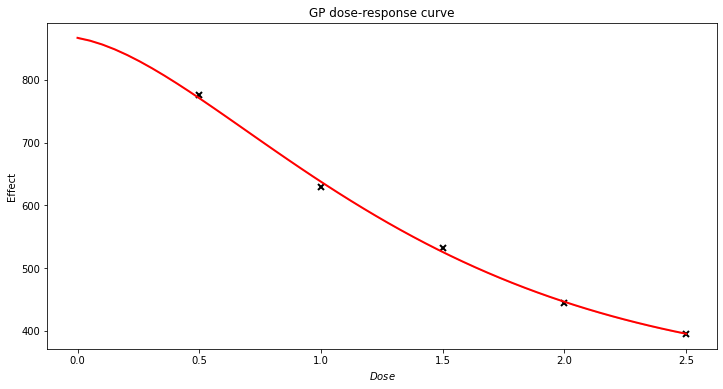

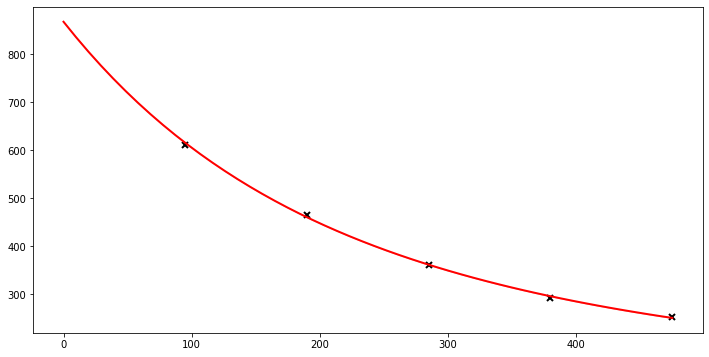

In [161]:

## plot
plt.figure(figsize=(12, 6))
plt.plot(Dose_A, Effect_A, "kx", mew=2)
plt.plot(xx_A, mean2.loc[0],"C0", lw=2, color='red')
plt.fill_between(
    xx_A[:, 0],
    mean2.loc[0] - 1.96 * np.sqrt(Cov2.loc[0]),
    mean2.loc[0] + 1.96 * np.sqrt( Cov2.loc[0]),
    color="red",
    alpha=0.2
)
#plt.ylim((0.0, 1.0))
plt.title('GP dose-response curve')
plt.xlabel("$Dose$"), plt.ylabel("Effect")
plt.savefig(drug_name+'_DrugA_2drugs'+'.png')

## plot
plt.figure(figsize=(12, 6))
plt.plot(Dose_B, Effect_B, "kx", mew=2)
plt.plot(xx_B, mean2.iloc[:,0],"C0", lw=2, color='red')
plt.fill_between(
    xx_B[:, 0],
    mean2.iloc[:,0] - 1.96 * np.sqrt(Cov2.iloc[:,0]),
    mean2.iloc[:,0] + 1.96 * np.sqrt( Cov2.iloc[:,0]),
    color="red",
    alpha=0.2
)